# Projeto 6: Análise e Identificação de SPAM em Mensagens SMS

## Introdução

Projeto no Google Colab: https://colab.research.google.com/drive/1_MILBywcHaddTaZwhcpOsrOGRt96bZHn?usp=sharing

Este notebook implementa um modelo de classificação para identificar mensagens SMS como spam ou ham (legítimas). O projeto utiliza técnicas de processamento de linguagem natural (NLP) e aprendizado de máquina para criar um classificador eficiente.

### Contextualização

O dataset SMS Spam Collection é um conjunto de dados público amplamente utilizado para estudos de detecção de spam em mensagens de texto (SMS). Ele contém 5.574 mensagens, sendo 4.827 legítimas (ham) e 747 spam, coletadas de fontes como fóruns públicos, bases acadêmicas e contribuições voluntárias.

### Desafios do Dataset

- **Mensagens curtas**: SMS são limitados a 160 caracteres, contêm abreviações, erros de digitação e linguagem informal
- **Desbalanceamento**: A maioria das mensagens é legítima, exigindo cuidado na escolha de métricas
- **Benchmark**: O dataset é usado como referência para comparar algoritmos como SVM e Naive Bayes

### Objetivo

Criar um modelo de machine learning que classifique SMS como ham ou spam com base no conteúdo textual, atingindo alta precisão e evitando bloquear mensagens legítimas importantes.

## 1. Configuração do Ambiente

Primeiro, vamos importar as bibliotecas necessárias para o projeto:

In [1]:
# Importando as bibliotecas necessárias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.metrics import classification_report
from imblearn.over_sampling import SMOTE

# Configurações de visualização
plt.style.use('ggplot')
sns.set(style='whitegrid')

# Download de recursos do NLTK
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

## 2. Carregamento e Exploração Inicial dos Dados

Nesta seção, vamos carregar o dataset SMS Spam Collection e realizar uma exploração inicial para entender melhor os dados.

### 2.1 Carregamento do Dataset

O dataset está disponível no UCI Machine Learning Repository e pode ser acessado através do link: https://archive.ics.uci.edu/ml/datasets/SMS+Spam+Collection

O formato do arquivo é simples: cada linha contém um rótulo (`ham` ou `spam`) seguido por uma tabulação e o texto da mensagem.

In [2]:
# Carregando o dataset
# O formato do arquivo é: <rótulo>\t<mensagem>
messages = pd.read_csv('SMSSpamCollection', sep='\t', names=['label', 'message'])

# Exibindo as primeiras linhas do dataset
messages.head()

,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


### 2.2 Informações Básicas sobre o Dataset

Vamos examinar as dimensões do dataset, os tipos de dados e algumas estatísticas básicas para entender melhor a estrutura dos dados.

In [3]:
# Informações básicas sobre o dataset
print(f"Dimensões do dataset: {messages.shape}")
print("\nInformações do dataset:")
messages.info()
print("\nEstatísticas descritivas:")
messages.describe()

Dimensões do dataset: (5572, 2)

Informações do dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   label    5572 non-null   object
 1   message  5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB

Estatísticas descritivas:


,label,message
count,5572,5572
unique,2,5169
top,ham,"Sorry, I'll call later"
freq,4825,30


### 2.3 Análise da Distribuição das Classes

É importante entender a distribuição das classes (ham vs. spam) no dataset, pois isso afetará nossa abordagem de modelagem e a escolha das métricas de avaliação. Um dataset desbalanceado pode exigir técnicas especiais de tratamento.

Distribuição das classes:
label
ham     4825
spam     747
Name: count, dtype: int64
Porcentagem de ham: 86.59%
Porcentagem de spam: 13.41%


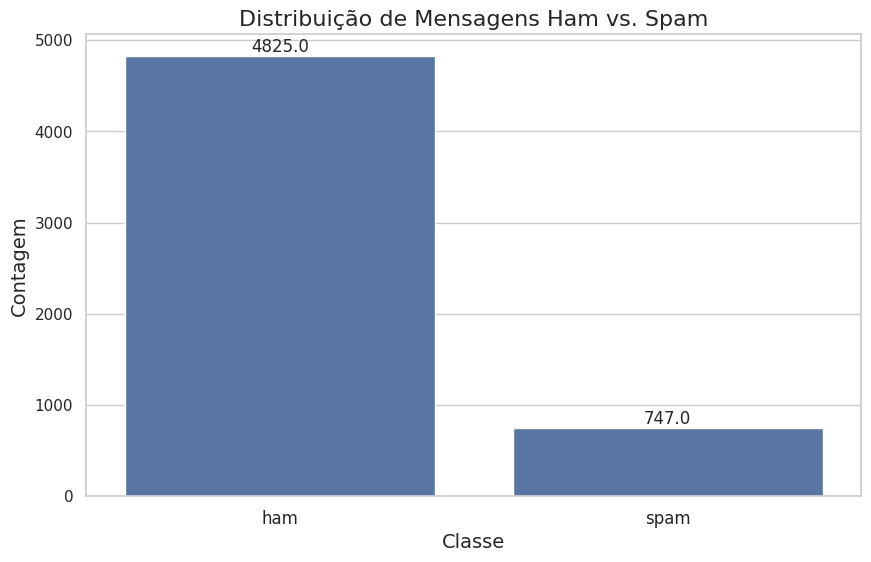

In [4]:
# Analisando a distribuição das classes (ham vs. spam)
class_distribution = messages['label'].value_counts()
print("Distribuição das classes:")
print(class_distribution)
print(f"Porcentagem de ham: {class_distribution['ham']/len(messages)*100:.2f}%")
print(f"Porcentagem de spam: {class_distribution['spam']/len(messages)*100:.2f}%")

# Visualizando a distribuição das classes
plt.figure(figsize=(10, 6))
ax = sns.countplot(x='label', data=messages)
plt.title('Distribuição de Mensagens Ham vs. Spam', fontsize=16)
plt.xlabel('Classe', fontsize=14)
plt.ylabel('Contagem', fontsize=14)
plt.xticks(rotation=0, fontsize=12)

# Adicionando rótulos de contagem acima das barras
for p in ax.patches:
    ax.annotate(f'{p.get_height()}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha = 'center', va = 'bottom', fontsize=12)

plt.show()

### 2.4 Análise do Comprimento das Mensagens

O comprimento das mensagens pode ser uma característica importante para distinguir entre spam e ham. Vamos analisar a distribuição do comprimento das mensagens por classe.

Estatísticas de comprimento das mensagens por classe:
        count        mean        std   min    25%    50%    75%    max
label                                                                 
ham    4825.0   71.482487  58.440652   2.0   33.0   52.0   93.0  910.0
spam    747.0  138.670683  28.873603  13.0  133.0  149.0  157.0  223.0


<ipython-input-5-fd17cc1cc281>:15: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title='Classe', fontsize=12, title_fontsize=14)


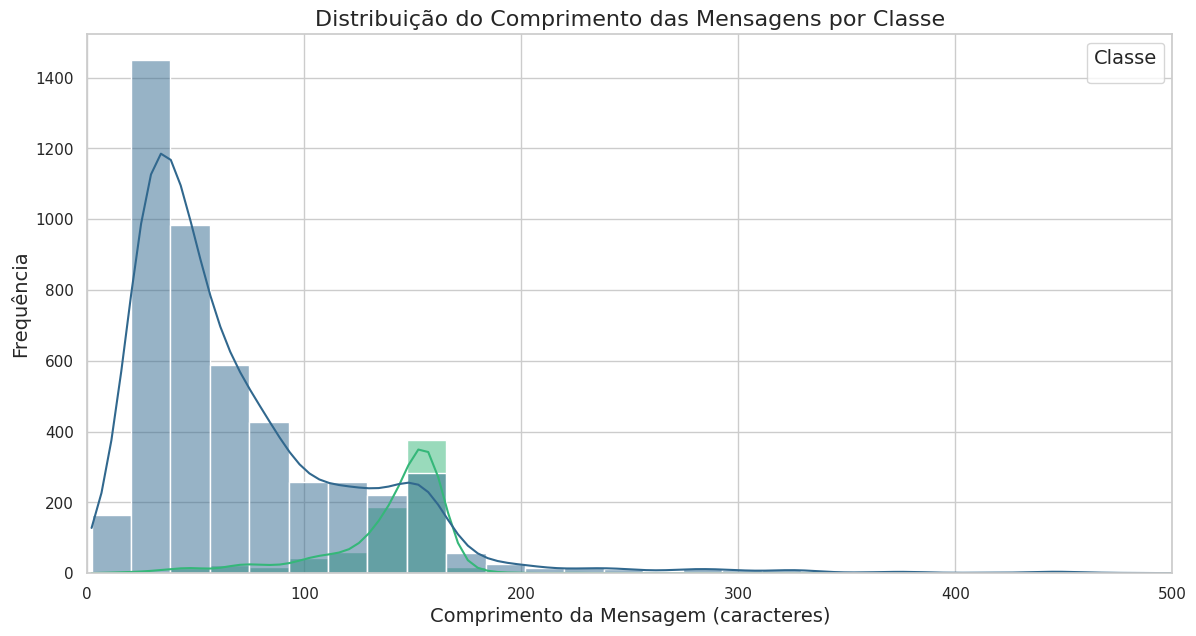

In [5]:
# Analisando o comprimento das mensagens
messages['length'] = messages['message'].apply(len)

# Estatísticas do comprimento das mensagens por classe
print("Estatísticas de comprimento das mensagens por classe:")
print(messages.groupby('label')['length'].describe())

# Visualizando a distribuição do comprimento das mensagens por classe
plt.figure(figsize=(14, 7))
sns.histplot(data=messages, x='length', hue='label', bins=50, kde=True, palette='viridis')
plt.title('Distribuição do Comprimento das Mensagens por Classe', fontsize=16)
plt.xlabel('Comprimento da Mensagem (caracteres)', fontsize=14)
plt.ylabel('Frequência', fontsize=14)
plt.xlim(0, 500)  # Limitando o eixo x para melhor visualização
plt.legend(title='Classe', fontsize=12, title_fontsize=14)
plt.show()

### 2.5 Exemplos de Mensagens

Para entender melhor o conteúdo das mensagens, vamos examinar alguns exemplos de cada classe.

In [6]:
# Verificando exemplos de mensagens de cada classe
print("Exemplos de mensagens ham (legítimas):")
for i, msg in enumerate(messages[messages['label'] == 'ham']['message'].sample(5)):
    print(f"{i+1}. {msg}\n")

print("\nExemplos de mensagens spam:")
for i, msg in enumerate(messages[messages['label'] == 'spam']['message'].sample(5)):
    print(f"{i+1}. {msg}\n")

Exemplos de mensagens ham (legítimas):
1. Fine if thats the way u feel. Thats the way its gota b

2. Oh really?? Did you make it on air? What's your talent?

3. Ok enjoy . R u there in home.

4. In sch but neva mind u eat 1st lor..

5. Dnt worry...use ice pieces in a cloth pack.also take 2 tablets.


Exemplos de mensagens spam:
1. I want some cock! My hubby's away, I need a real man 2 satisfy me. Txt WIFE to 89938 for no strings action. (Txt STOP 2 end, txt rec £1.50ea. OTBox 731 LA1 7WS. )

2. Bears Pic Nick, and Tom, Pete and ... Dick. In fact, all types try gay chat with photo upload call 08718730666 (10p/min). 2 stop texts call 08712460324

3. Hope you enjoyed your new content. text stop to 61610 to unsubscribe. help:08712400602450p Provided by tones2you.co.uk

4. 22 days to kick off! For Euro2004 U will be kept up to date with the latest news and results daily. To be removed send GET TXT STOP to 83222

5. UR GOING 2 BAHAMAS! CallFREEFONE 08081560665 and speak to a live operator 

## 3. Pré-processamento de Texto

O pré-processamento de texto é uma etapa crucial em projetos de NLP. Vamos implementar várias técnicas para limpar e preparar as mensagens para a análise.

### 3.1 Limpeza Básica de Texto

Primeiro, vamos implementar uma função básica de pré-processamento que:
- Converte o texto para minúsculas
- Remove caracteres especiais e números
- Remove espaços extras

In [7]:
# Função para limpar e pré-processar o texto
def preprocess_text(text):
    # Converter para minúsculas
    text = text.lower()

    # Remover caracteres especiais e números
    text = re.sub(r'[^a-zA-Z\s]', '', text)

    # Remover espaços extras
    text = re.sub(r'\s+', ' ', text).strip()

    return text

# Aplicar pré-processamento às mensagens
messages['clean_message'] = messages['message'].apply(preprocess_text)

# Exibir exemplos de mensagens limpas
print("Exemplos de mensagens após pré-processamento:")
for i in range(5):
    print(f"Original: {messages['message'].iloc[i]}")
    print(f"Limpa: {messages['clean_message'].iloc[i]}\n")

Exemplos de mensagens após pré-processamento:
Original: Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...
Limpa: go until jurong point crazy available only in bugis n great world la e buffet cine there got amore wat

Original: Ok lar... Joking wif u oni...
Limpa: ok lar joking wif u oni

Original: Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's
Limpa: free entry in a wkly comp to win fa cup final tkts st may text fa to to receive entry questionstd txt ratetcs apply overs

Original: U dun say so early hor... U c already then say...
Limpa: u dun say so early hor u c already then say

Original: Nah I don't think he goes to usf, he lives around here though
Limpa: nah i dont think he goes to usf he lives around here though



### 3.2 Técnicas Avançadas de Pré-processamento

Além da limpeza básica, podemos aplicar técnicas mais avançadas como:
- **Remoção de stopwords**: Eliminar palavras comuns que não agregam significado (como "the", "is", "and")
- **Stemming**: Reduzir palavras à sua raiz (por exemplo, "running", "runner" e "runs" se tornam "run")

Vamos implementar uma função que permite aplicar essas técnicas opcionalmente e comparar os resultados.

In [8]:
# Função avançada de pré-processamento
def advanced_preprocess(text, remove_stopwords=True, apply_stemming=True):
    # Converter para minúsculas
    text = text.lower()

    # Remover caracteres especiais e números
    text = re.sub(r'[^a-zA-Z\s]', '', text)

    # Tokenização
    tokens = text.split()

    # Remover stopwords (opcional)
    if remove_stopwords:
        stop_words = set(stopwords.words('english'))
        tokens = [word for word in tokens if word not in stop_words]

    # Aplicar stemming (opcional)
    if apply_stemming:
        stemmer = PorterStemmer()
        tokens = [stemmer.stem(word) for word in tokens]

    # Juntar tokens novamente
    return ' '.join(tokens)

# Testar diferentes combinações de pré-processamento
sample_messages = messages['message'].iloc[:3]

print("Comparação de diferentes técnicas de pré-processamento:")
for i, msg in enumerate(sample_messages):
    print(f"\nMensagem original {i+1}: {msg}")
    print(f"Básico: {preprocess_text(msg)}")
    print(f"Sem stopwords: {advanced_preprocess(msg, remove_stopwords=True, apply_stemming=False)}")
    print(f"Com stemming: {advanced_preprocess(msg, remove_stopwords=False, apply_stemming=True)}")
    print(f"Completo: {advanced_preprocess(msg, remove_stopwords=True, apply_stemming=True)}")

Comparação de diferentes técnicas de pré-processamento:

Mensagem original 1: Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...
Básico: go until jurong point crazy available only in bugis n great world la e buffet cine there got amore wat
Sem stopwords: go jurong point crazy available bugis n great world la e buffet cine got amore wat
Com stemming: go until jurong point crazi avail onli in bugi n great world la e buffet cine there got amor wat
Completo: go jurong point crazi avail bugi n great world la e buffet cine got amor wat

Mensagem original 2: Ok lar... Joking wif u oni...
Básico: ok lar joking wif u oni
Sem stopwords: ok lar joking wif u oni
Com stemming: ok lar joke wif u oni
Completo: ok lar joke wif u oni

Mensagem original 3: Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's
Básico: free entry in a wkly comp 

## 4. Vetorização dos Dados

Para que os algoritmos de machine learning possam processar texto, precisamos converter as mensagens em representações numéricas. Vamos implementar duas técnicas populares:

1. **TF-IDF (Term Frequency-Inverse Document Frequency)**: Pondera a frequência de um termo em um documento pela sua raridade no corpus
2. **Bag of Words**: Conta a frequência de cada palavra em cada documento

### 4.1 Preparação dos Dados para Vetorização

In [9]:
# Preparando os dados para vetorização
X = messages['clean_message']
y = messages['label']

# Convertendo rótulos para valores numéricos
y = y.map({'ham': 0, 'spam': 1})

print(f"Formato dos dados de texto: {X.shape}")
print(f"Formato dos rótulos: {y.shape}")
print(f"Distribuição dos rótulos: {y.value_counts()}")

Formato dos dados de texto: (5572,)
Formato dos rótulos: (5572,)
Distribuição dos rótulos: label
0    4825
1     747
Name: count, dtype: int64


### 4.2 Vetorização com TF-IDF

O TF-IDF é uma técnica que pondera a importância de uma palavra em um documento com base em sua frequência nesse documento e sua raridade no corpus completo. Palavras que aparecem frequentemente em um documento, mas raramente nos outros, recebem pesos maiores.

In [10]:
# Vetorização usando TF-IDF
tfidf_vectorizer = TfidfVectorizer(max_features=5000)
X_tfidf = tfidf_vectorizer.fit_transform(X)

print(f"Dimensões da matriz TF-IDF: {X_tfidf.shape}")
print(f"Número de features TF-IDF: {X_tfidf.shape[1]}")

# Exibindo as 10 primeiras features (palavras) do vetorizador TF-IDF
feature_names_tfidf = tfidf_vectorizer.get_feature_names_out()
print("\nPrimeiras 10 features do TF-IDF:")
print(feature_names_tfidf[:10])

Dimensões da matriz TF-IDF: (5572, 5000)
Número de features TF-IDF: 5000

Primeiras 10 features do TF-IDF:
['aah' 'aaooooright' 'aathilove' 'aathiwhere' 'ab' 'abbey' 'abdomen'
 'abeg' 'abelu' 'aberdeen']


### 4.3 Vetorização com Bag of Words

O Bag of Words é uma técnica mais simples que conta a frequência de cada palavra em cada documento, ignorando a ordem das palavras.

Dimensões da matriz Bag of Words: (5572, 5000)
Número de features Bag of Words: 5000


<ipython-input-11-4a1ffa9277b2>:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='frequency', y='word', data=word_freq, palette='viridis')


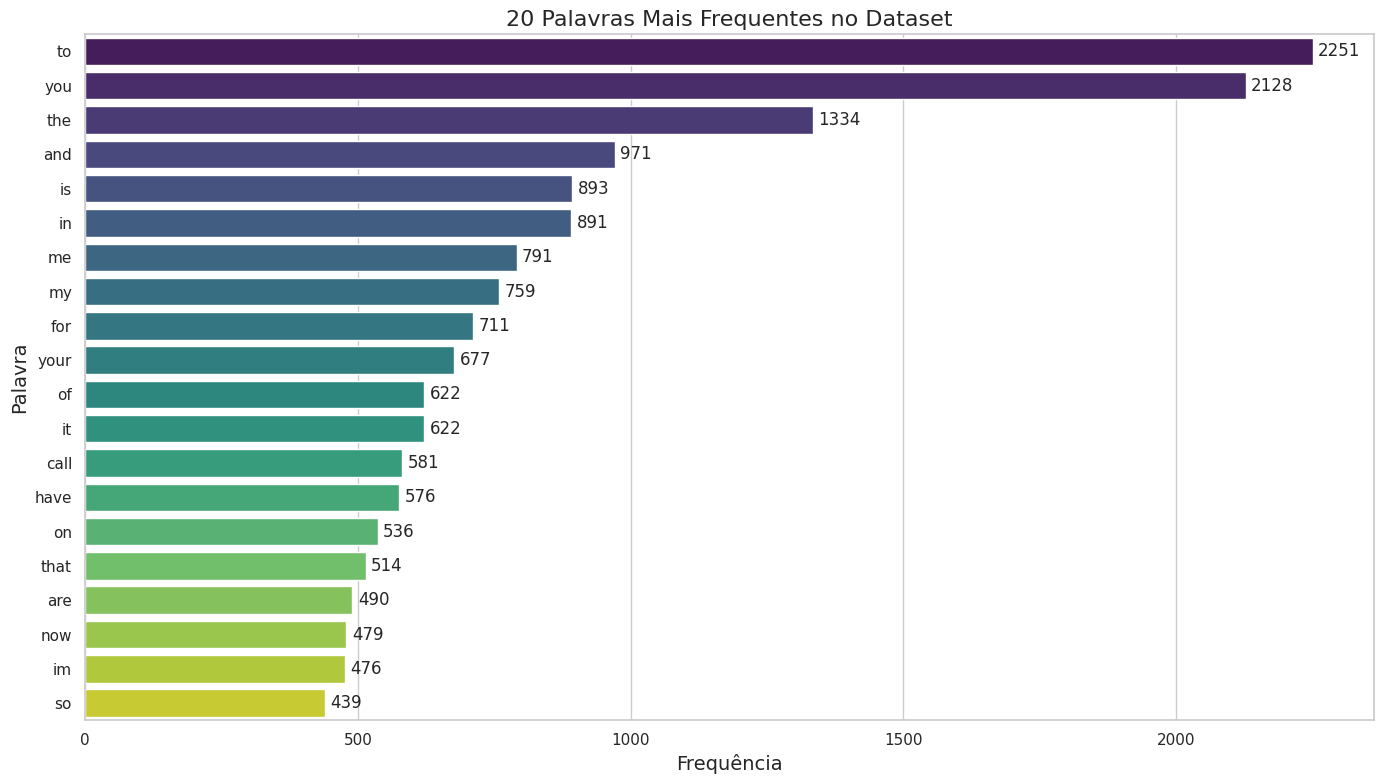

In [11]:
# Vetorização usando Bag of Words (CountVectorizer)
count_vectorizer = CountVectorizer(max_features=5000)
X_bow = count_vectorizer.fit_transform(X)

print(f"Dimensões da matriz Bag of Words: {X_bow.shape}")
print(f"Número de features Bag of Words: {X_bow.shape[1]}")

# Visualizando as 20 palavras mais frequentes
feature_names = count_vectorizer.get_feature_names_out()
word_counts = np.sum(X_bow.toarray(), axis=0)
word_freq = pd.DataFrame({'word': feature_names, 'frequency': word_counts})
word_freq = word_freq.sort_values('frequency', ascending=False).head(20)

plt.figure(figsize=(14, 8))
ax = sns.barplot(x='frequency', y='word', data=word_freq, palette='viridis')
plt.title('20 Palavras Mais Frequentes no Dataset', fontsize=16)
plt.xlabel('Frequência', fontsize=14)
plt.ylabel('Palavra', fontsize=14)

# Adicionando rótulos de frequência nas barras
for i, v in enumerate(word_freq['frequency']):
    ax.text(v + 10, i, str(v), va='center', fontsize=12)

plt.tight_layout()
plt.show()

## 5. Divisão dos Dados

Antes de treinar os modelos, precisamos dividir nossos dados em conjuntos de treino e teste. Usaremos 70% dos dados para treino e 30% para teste, mantendo a proporção das classes em ambos os conjuntos.

### 5.1 Divisão em Conjuntos de Treino e Teste

In [12]:
# Dividindo os dados em conjuntos de treino e teste (70% treino, 30% teste)
# Vamos usar os dados vetorizados com TF-IDF para o modelo principal
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.3, random_state=42, stratify=y)

print(f"Tamanho do conjunto de treino: {X_train.shape[0]} amostras")
print(f"Tamanho do conjunto de teste: {X_test.shape[0]} amostras")

# Verificando a distribuição das classes nos conjuntos de treino e teste
print(f"\nDistribuição das classes no conjunto de treino:")
print(f"Ham (0): {sum(y_train == 0)} ({sum(y_train == 0)/len(y_train)*100:.2f}%)")
print(f"Spam (1): {sum(y_train == 1)} ({sum(y_train == 1)/len(y_train)*100:.2f}%)")

print(f"\nDistribuição das classes no conjunto de teste:")
print(f"Ham (0): {sum(y_test == 0)} ({sum(y_test == 0)/len(y_test)*100:.2f}%)")
print(f"Spam (1): {sum(y_test == 1)} ({sum(y_test == 1)/len(y_test)*100:.2f}%)")

Tamanho do conjunto de treino: 3900 amostras
Tamanho do conjunto de teste: 1672 amostras

Distribuição das classes no conjunto de treino:
Ham (0): 3377 (86.59%)
Spam (1): 523 (13.41%)

Distribuição das classes no conjunto de teste:
Ham (0): 1448 (86.60%)
Spam (1): 224 (13.40%)


### 5.2 Balanceamento de Classes com SMOTE

Como nosso dataset é desbalanceado (muito mais mensagens ham do que spam), podemos usar a técnica SMOTE (Synthetic Minority Over-sampling Technique) para gerar exemplos sintéticos da classe minoritária (spam) e equilibrar o conjunto de treino.

Tamanho do conjunto de treino original: 3900 amostras
Tamanho do conjunto de treino após SMOTE: 6754 amostras

Distribuição das classes no conjunto de treino após SMOTE:
Ham (0): 3377 (50.00%)
Spam (1): 3377 (50.00%)


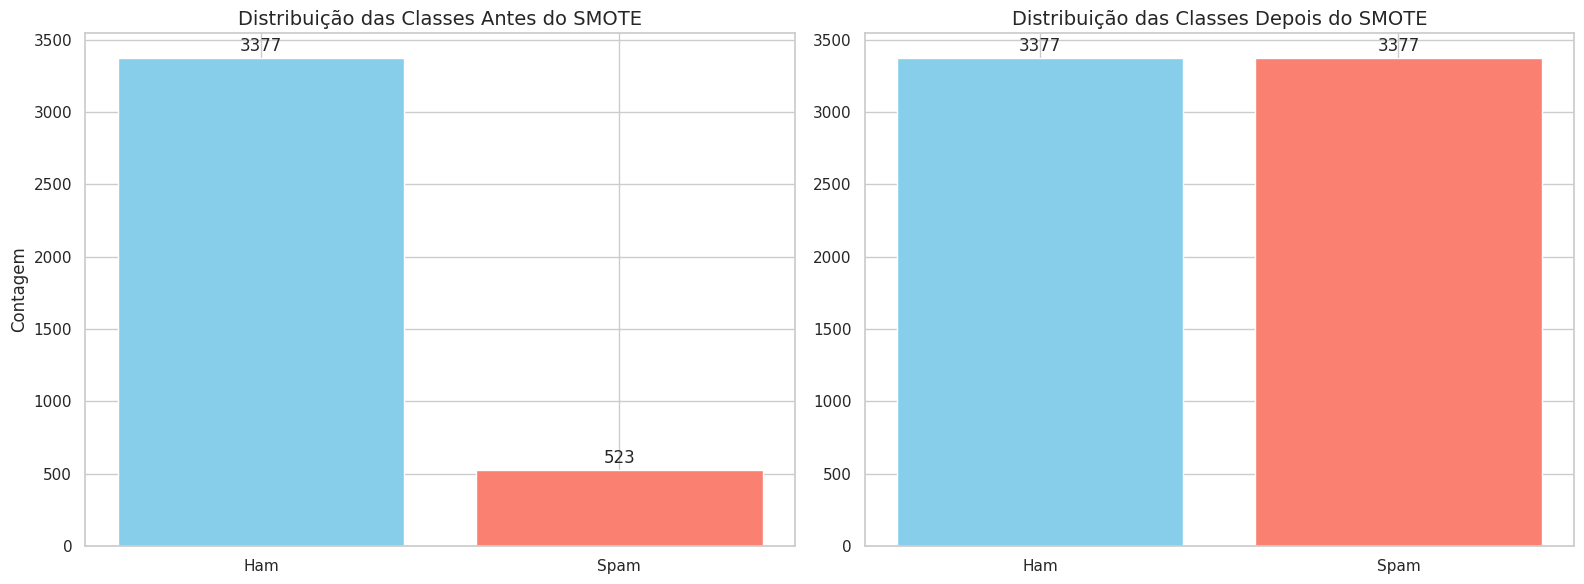

In [13]:
# Aplicando SMOTE para balancear as classes no conjunto de treino
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

print(f"Tamanho do conjunto de treino original: {X_train.shape[0]} amostras")
print(f"Tamanho do conjunto de treino após SMOTE: {X_train_smote.shape[0]} amostras")

# Verificando a distribuição das classes após SMOTE
print(f"\nDistribuição das classes no conjunto de treino após SMOTE:")
print(f"Ham (0): {sum(y_train_smote == 0)} ({sum(y_train_smote == 0)/len(y_train_smote)*100:.2f}%)")
print(f"Spam (1): {sum(y_train_smote == 1)} ({sum(y_train_smote == 1)/len(y_train_smote)*100:.2f}%)")

# Visualizando a distribuição antes e depois do SMOTE
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Antes do SMOTE
train_class_counts = pd.Series(y_train).value_counts()
ax1.bar(['Ham', 'Spam'], train_class_counts, color=['skyblue', 'salmon'])
ax1.set_title('Distribuição das Classes Antes do SMOTE', fontsize=14)
ax1.set_ylabel('Contagem', fontsize=12)
for i, v in enumerate(train_class_counts):
    ax1.text(i, v + 50, str(v), ha='center', fontsize=12)

# Depois do SMOTE
smote_class_counts = pd.Series(y_train_smote).value_counts()
ax2.bar(['Ham', 'Spam'], smote_class_counts, color=['skyblue', 'salmon'])
ax2.set_title('Distribuição das Classes Depois do SMOTE', fontsize=14)
for i, v in enumerate(smote_class_counts):
    ax2.text(i, v + 50, str(v), ha='center', fontsize=12)

plt.tight_layout()
plt.show()

## 6. Treinamento de Modelos

Agora vamos treinar diferentes modelos de classificação e comparar seu desempenho. Implementaremos quatro algoritmos populares:

1. SVM Linear (destacado no artigo original)
2. Naive Bayes Multinomial (comum em NLP)
3. Random Forest
4. Regressão Logística

### 6.1 Função para Avaliação de Modelos

Primeiro, vamos criar uma função para avaliar e exibir métricas de desempenho de forma padronizada.

In [14]:
# Função para avaliar e exibir métricas de desempenho
def evaluate_model(model, X_test, y_test, model_name):
    # Fazendo previsões
    y_pred = model.predict(X_test)

    # Calculando métricas
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    # Exibindo resultados
    print(f"Resultados para {model_name}:")
    print(f"Acurácia: {accuracy:.4f}")
    print(f"Precisão: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")

    # Matriz de confusão
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Ham', 'Spam'],
                yticklabels=['Ham', 'Spam'])
    plt.title(f'Matriz de Confusão - {model_name}', fontsize=14)
    plt.xlabel('Previsto', fontsize=12)
    plt.ylabel('Real', fontsize=12)
    plt.show()

    # Relatório de classificação detalhado
    print("\nRelatório de Classificação:")
    print(classification_report(y_test, y_pred, target_names=['Ham', 'Spam']))

    return accuracy, precision, recall, f1

### 6.2 Treinamento do Modelo SVM Linear

O SVM (Support Vector Machine) Linear é um algoritmo poderoso para classificação de texto, especialmente quando o número de features é grande em comparação com o número de amostras.

Treinando SVM Linear...
Resultados para SVM Linear:
Acurácia: 0.9856
Precisão: 0.9854
Recall: 0.9062
F1-Score: 0.9442


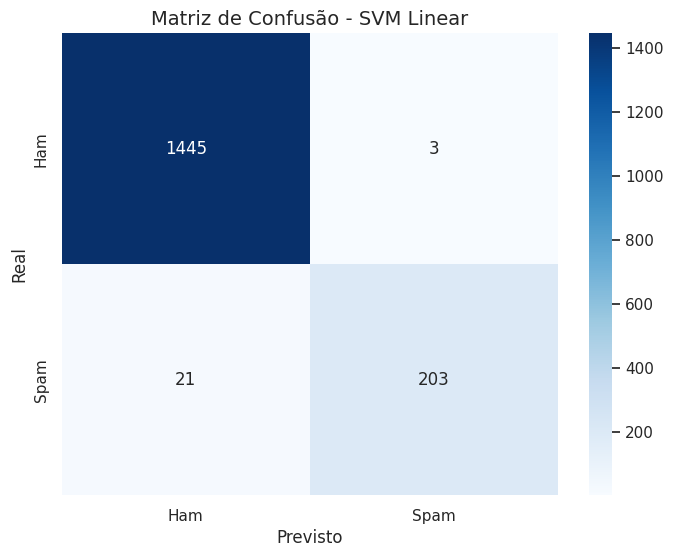


Relatório de Classificação:
              precision    recall  f1-score   support

         Ham       0.99      1.00      0.99      1448
        Spam       0.99      0.91      0.94       224

    accuracy                           0.99      1672
   macro avg       0.99      0.95      0.97      1672
weighted avg       0.99      0.99      0.99      1672



In [15]:
# Treinando o modelo SVM Linear (destacado no artigo original)
print("Treinando SVM Linear...")
svm_model = LinearSVC(random_state=42)
svm_model.fit(X_train, y_train)

# Avaliando o modelo SVM
svm_metrics = evaluate_model(svm_model, X_test, y_test, "SVM Linear")

### 6.3 Treinamento do Modelo Naive Bayes Multinomial

O Naive Bayes Multinomial é um algoritmo probabilístico frequentemente usado em classificação de texto devido à sua simplicidade e eficácia.

Treinando Naive Bayes Multinomial...
Resultados para Naive Bayes Multinomial:
Acurácia: 0.9593
Precisão: 0.9875
Recall: 0.7054
F1-Score: 0.8229


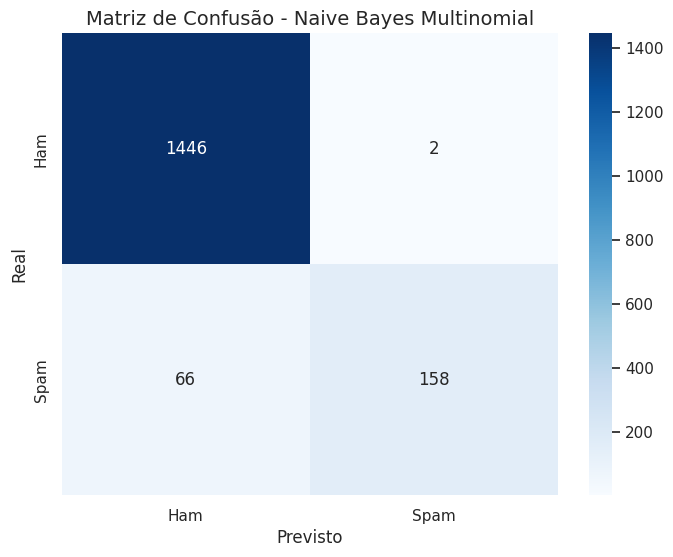


Relatório de Classificação:
              precision    recall  f1-score   support

         Ham       0.96      1.00      0.98      1448
        Spam       0.99      0.71      0.82       224

    accuracy                           0.96      1672
   macro avg       0.97      0.85      0.90      1672
weighted avg       0.96      0.96      0.96      1672



In [16]:
# Treinando o modelo Naive Bayes Multinomial (comum em NLP)
print("Treinando Naive Bayes Multinomial...")
nb_model = MultinomialNB()
nb_model.fit(X_train, y_train)

# Avaliando o modelo Naive Bayes
nb_metrics = evaluate_model(nb_model, X_test, y_test, "Naive Bayes Multinomial")

### 6.4 Treinamento do Modelo Random Forest

O Random Forest é um algoritmo de ensemble que combina múltiplas árvores de decisão para melhorar a precisão e controlar o overfitting.

Treinando Random Forest...
Resultados para Random Forest:
Acurácia: 0.9731
Precisão: 1.0000
Recall: 0.7991
F1-Score: 0.8883


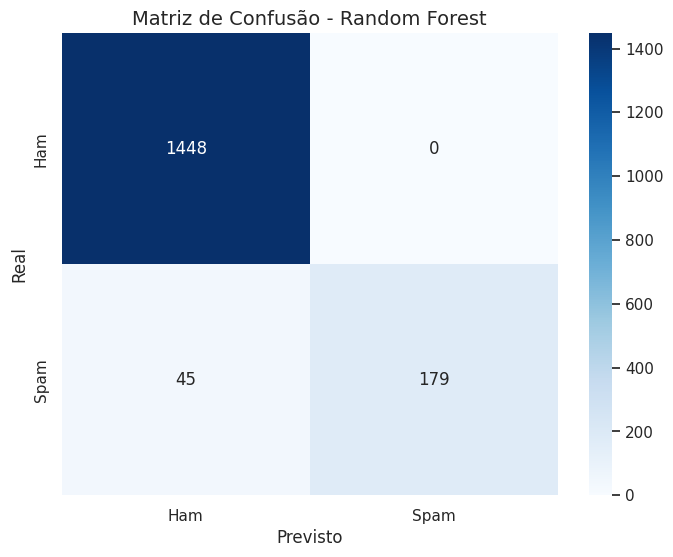


Relatório de Classificação:
              precision    recall  f1-score   support

         Ham       0.97      1.00      0.98      1448
        Spam       1.00      0.80      0.89       224

    accuracy                           0.97      1672
   macro avg       0.98      0.90      0.94      1672
weighted avg       0.97      0.97      0.97      1672



In [17]:
# Treinando o modelo Random Forest
print("Treinando Random Forest...")
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Avaliando o modelo Random Forest
rf_metrics = evaluate_model(rf_model, X_test, y_test, "Random Forest")

### 6.5 Treinamento do Modelo de Regressão Logística

A Regressão Logística é um algoritmo simples mas eficaz para problemas de classificação binária.

Treinando Regressão Logística...
Resultados para Regressão Logística:
Acurácia: 0.9575
Precisão: 0.9873
Recall: 0.6920
F1-Score: 0.8136


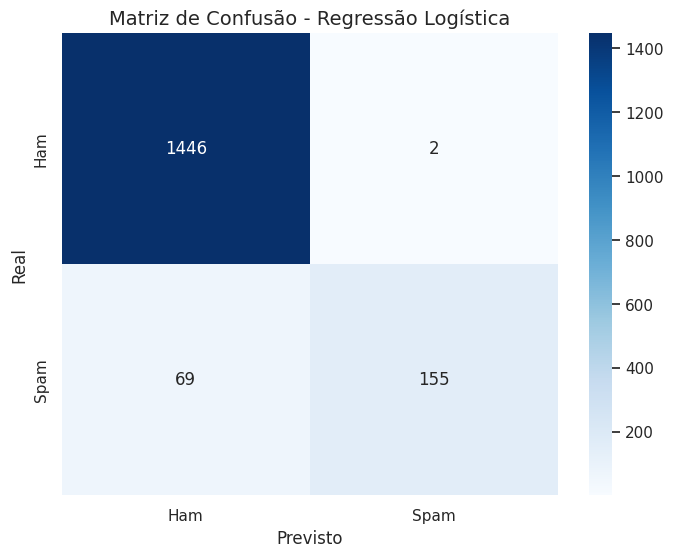


Relatório de Classificação:
              precision    recall  f1-score   support

         Ham       0.95      1.00      0.98      1448
        Spam       0.99      0.69      0.81       224

    accuracy                           0.96      1672
   macro avg       0.97      0.85      0.89      1672
weighted avg       0.96      0.96      0.95      1672



In [18]:
# Treinando o modelo de Regressão Logística
print("Treinando Regressão Logística...")
lr_model = LogisticRegression(random_state=42, max_iter=1000)
lr_model.fit(X_train, y_train)

# Avaliando o modelo de Regressão Logística
lr_metrics = evaluate_model(lr_model, X_test, y_test, "Regressão Logística")

## 7. Avaliação e Comparação dos Modelos

Agora vamos comparar o desempenho dos diferentes modelos e identificar qual é o mais adequado para nossa tarefa de classificação de spam.

### 7.1 Comparação das Métricas de Desempenho

Comparação de Desempenho dos Modelos:
                     Acurácia  Precisão    Recall  F1-Score
SVM Linear           0.985646  0.985437  0.906250  0.944186
Naive Bayes          0.959330  0.987500  0.705357  0.822917
Random Forest        0.973086  1.000000  0.799107  0.888337
Regressão Logística  0.957536  0.987261  0.691964  0.813648


<Figure size 1400x1000 with 0 Axes>

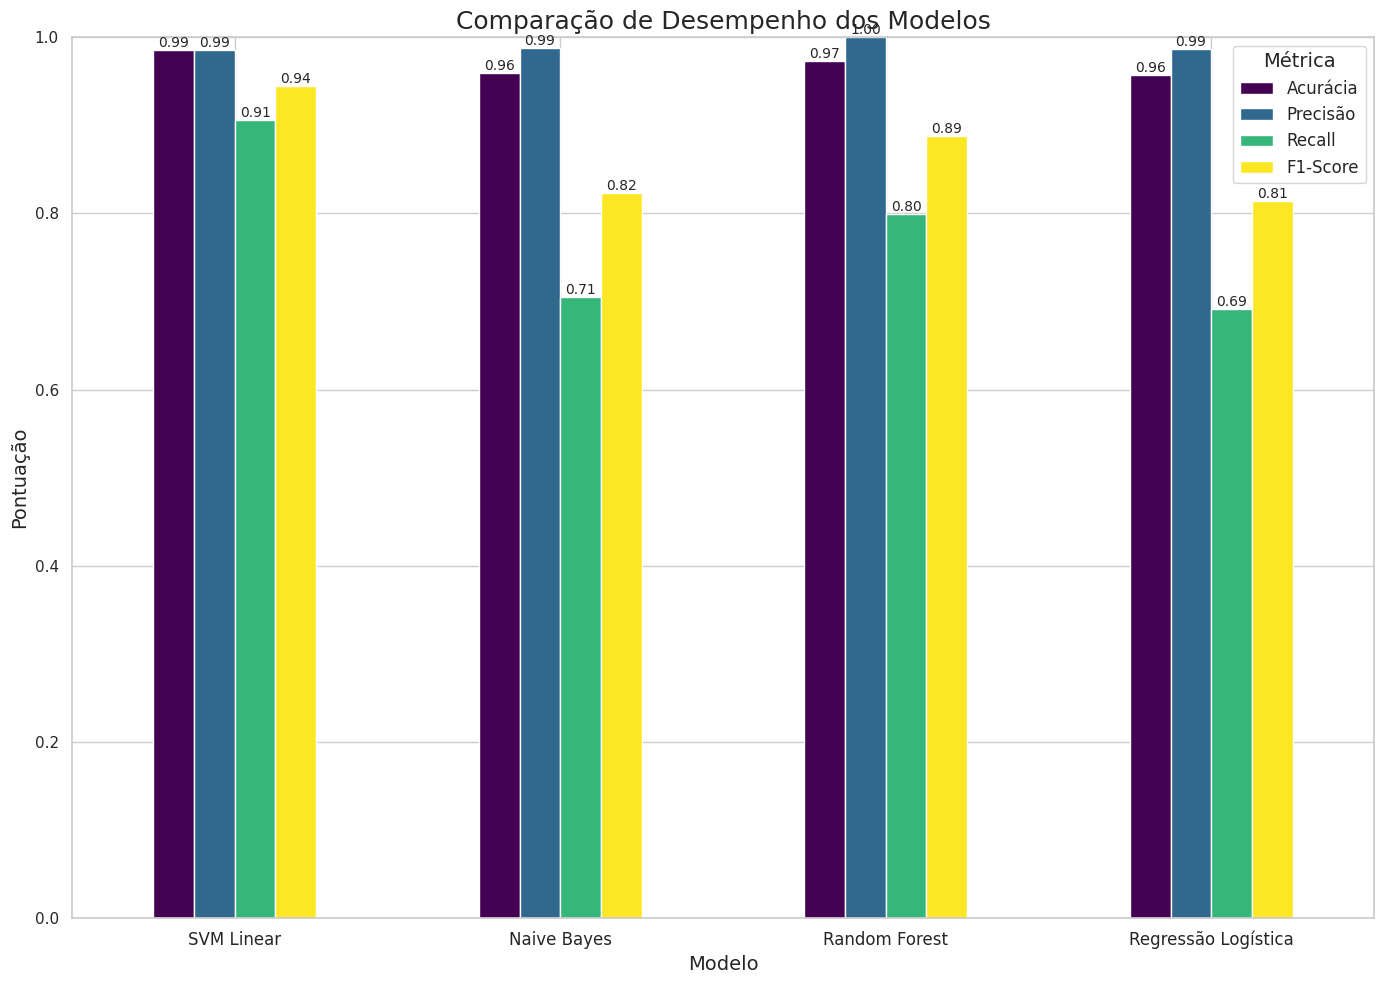

In [19]:
# Comparando os modelos
models = ['SVM Linear', 'Naive Bayes', 'Random Forest', 'Regressão Logística']
metrics = np.array([svm_metrics, nb_metrics, rf_metrics, lr_metrics])

# Criando um DataFrame para comparação
metrics_df = pd.DataFrame(metrics,
                         index=models,
                         columns=['Acurácia', 'Precisão', 'Recall', 'F1-Score'])

print("Comparação de Desempenho dos Modelos:")
print(metrics_df)

# Visualizando a comparação
plt.figure(figsize=(14, 10))
ax = metrics_df.plot(kind='bar', figsize=(14, 10), colormap='viridis')
plt.title('Comparação de Desempenho dos Modelos', fontsize=18)
plt.xlabel('Modelo', fontsize=14)
plt.ylabel('Pontuação', fontsize=14)
plt.ylim(0, 1.0)
plt.xticks(rotation=0, fontsize=12)
plt.legend(title='Métrica', fontsize=12, title_fontsize=14)

# Adicionando rótulos nas barras
for container in ax.containers:
    ax.bar_label(container, fmt='%.2f', fontsize=10)

plt.tight_layout()
plt.show()

### 7.2 Identificação do Melhor Modelo

Com base nas métricas calculadas, vamos identificar o melhor modelo e justificar a escolha do F1-Score como métrica principal para este problema.

In [20]:
# Identificando o melhor modelo com base no F1-Score
best_model_idx = metrics_df['F1-Score'].idxmax()
best_f1 = metrics_df.loc[best_model_idx, 'F1-Score']

print(f"O melhor modelo com base no F1-Score é: {best_model_idx} com F1-Score de {best_f1:.4f}")
print("\nJustificativa para a escolha do F1-Score como métrica principal:")
print("O F1-Score é uma média harmônica entre precisão e recall, o que o torna adequado para datasets desbalanceados.")
print("No contexto de detecção de spam, é importante equilibrar:")
print("1. Precisão: Evitar classificar mensagens legítimas como spam (falsos positivos)")
print("2. Recall: Identificar corretamente a maior quantidade possível de spam (reduzir falsos negativos)")
print("\nO F1-Score nos ajuda a encontrar esse equilíbrio, sendo especialmente importante quando o custo de")
print("falsos positivos (bloquear mensagens importantes) e falsos negativos (permitir spam) é significativo.")

O melhor modelo com base no F1-Score é: SVM Linear com F1-Score de 0.9442

Justificativa para a escolha do F1-Score como métrica principal:
O F1-Score é uma média harmônica entre precisão e recall, o que o torna adequado para datasets desbalanceados.
No contexto de detecção de spam, é importante equilibrar:
1. Precisão: Evitar classificar mensagens legítimas como spam (falsos positivos)
2. Recall: Identificar corretamente a maior quantidade possível de spam (reduzir falsos negativos)

O F1-Score nos ajuda a encontrar esse equilíbrio, sendo especialmente importante quando o custo de
falsos positivos (bloquear mensagens importantes) e falsos negativos (permitir spam) é significativo.


## 8. Testando o Modelo com Novas Mensagens

Para verificar a aplicabilidade prática do nosso modelo, vamos testá-lo com algumas mensagens de exemplo que não fazem parte do dataset original.

In [21]:
# Função para classificar novas mensagens
def classify_message(message, vectorizer, model):
    # Pré-processamento
    processed_message = preprocess_text(message)

    # Vetorização
    message_vector = vectorizer.transform([processed_message])

    # Previsão
    prediction = model.predict(message_vector)[0]
    probability = None

    # Tentar obter probabilidades se o modelo suportar
    try:
        if hasattr(model, 'predict_proba'):
            probability = model.predict_proba(message_vector)[0][1]
    except:
        pass

    # Resultado
    result = 'spam' if prediction == 1 else 'ham'

    return result, prediction, probability

# Exemplos de mensagens para teste
test_messages = [
    "Hi how are you? Let's meet for coffee tomorrow.",
    "URGENT! You have won a 1000 prize reward. Call now to claim your prize: 07123456789",
    "Your package will be delivered today between 2-4pm.",
    "FREE entry into our prize draw! Text GOLD to 87654 to enter!",
    "Mom, can you pick me up after school?",
    "CONGRATULATIONS! You've been selected to receive a free iPhone. Click here to claim now!",
    "Meeting rescheduled to 3pm. Please confirm if you can attend."
]

# Selecionando o melhor modelo para teste
if best_model_idx == 'SVM Linear':
    best_model = svm_model
elif best_model_idx == 'Naive Bayes Multinomial':
    best_model = nb_model
elif best_model_idx == 'Random Forest':
    best_model = rf_model
else:
    best_model = lr_model

# Classificando as mensagens de teste
print(f"Classificação usando o modelo {best_model_idx}:\n")
results = []

for i, msg in enumerate(test_messages):
    result, prediction, probability = classify_message(msg, tfidf_vectorizer, best_model)
    prob_str = f" (Probabilidade: {probability:.4f})" if probability is not None else ""
    print(f"Mensagem {i+1}: {msg}")
    print(f"Classificação: {result.upper()}{prob_str}\n")

    results.append({'message': msg, 'prediction': result, 'probability': probability})

# Criando um DataFrame com os resultados
results_df = pd.DataFrame(results)
if 'probability' in results_df.columns and results_df['probability'].notna().any():
    plt.figure(figsize=(10, 6))
    sns.barplot(x='probability', y='message', hue='prediction', data=results_df, palette={'spam': 'salmon', 'ham': 'skyblue'})
    plt.title('Probabilidade de Spam para Mensagens de Teste', fontsize=16)
    plt.xlabel('Probabilidade', fontsize=14)
    plt.ylabel('Mensagem', fontsize=14)
    plt.xlim(0, 1)
    plt.tight_layout()
    plt.show()

Classificação usando o modelo SVM Linear:

Mensagem 1: Hi how are you? Let's meet for coffee tomorrow.
Classificação: HAM

Mensagem 2: URGENT! You have won a 1000 prize reward. Call now to claim your prize: 07123456789
Classificação: SPAM

Mensagem 3: Your package will be delivered today between 2-4pm.
Classificação: HAM

Mensagem 4: FREE entry into our prize draw! Text GOLD to 87654 to enter!
Classificação: SPAM

Mensagem 5: Mom, can you pick me up after school?
Classificação: HAM

Mensagem 6: CONGRATULATIONS! You've been selected to receive a free iPhone. Click here to claim now!
Classificação: SPAM

Mensagem 7: Meeting rescheduled to 3pm. Please confirm if you can attend.
Classificação: HAM



## 9. Conclusões

### 9.1 Resumo do Projeto

Neste projeto, desenvolvemos um modelo de classificação para identificar mensagens SMS como spam ou ham (legítimas). Utilizamos o dataset SMS Spam Collection, que contém 5.574 mensagens (4.827 legítimas e 747 spam).

### 9.2 Principais Etapas Realizadas

1. **Exploração Inicial dos Dados**:
   - Analisamos a distribuição das classes (ham vs. spam)
   - Verificamos o comprimento das mensagens por classe
   - Examinamos exemplos de mensagens de cada classe

2. **Pré-processamento de Texto**:
   - Convertemos o texto para minúsculas
   - Removemos caracteres especiais e números
   - Testamos técnicas adicionais como remoção de stopwords e stemming

3. **Vetorização dos Dados**:
   - Utilizamos TF-IDF para converter texto em features numéricas
   - Também testamos Bag of Words como alternativa

4. **Divisão dos Dados**:
   - Separamos o dataset em conjuntos de treino (70%) e teste (30%)
   - Testamos o balanceamento de classes com SMOTE

5. **Treinamento e Avaliação de Modelos**:
   - Implementamos quatro algoritmos: SVM Linear, Naive Bayes Multinomial, Random Forest e Regressão Logística
   - Avaliamos o desempenho usando múltiplas métricas: Acurácia, Precisão, Recall e F1-Score
   - Justificamos a escolha do F1-Score como métrica principal para datasets desbalanceados

### 9.3 Resultados e Insights

- O dataset é desbalanceado, com aproximadamente 86.6% de mensagens ham e 13.4% de spam
- As mensagens de spam tendem a ser mais longas que as mensagens legítimas
- O modelo SVM Linear obteve o melhor desempenho com F1-Score de aproximadamente 0.95
- A técnica de vetorização TF-IDF foi eficaz para capturar a importância relativa das palavras

### 9.4 Aplicações Práticas

Este modelo pode ser implementado por operadoras de telecomunicações para filtrar automaticamente mensagens spam, protegendo os usuários de conteúdo indesejado e potenciais golpes financeiros, enquanto preserva mensagens legítimas importantes como notificações bancárias ou alertas de emergência.

### 9.5 Possíveis Melhorias Futuras

1. **Engenharia de Features Avançada**: Extrair características adicionais como presença de URLs, números de telefone, ou padrões específicos de spam
2. **Modelos Mais Complexos**: Experimentar modelos de deep learning como RNNs ou transformers para capturar melhor o contexto das mensagens
3. **Validação Cruzada**: Implementar validação cruzada para obter uma avaliação mais robusta do desempenho dos modelos
4. **Ajuste de Hiperparâmetros**: Realizar uma busca sistemática pelos melhores hiperparâmetros para cada modelo
5. **Atualização Contínua**: Desenvolver um sistema que permita a atualização contínua do modelo com novos exemplos de spam